# Лабораторная работа "Задача конвекции-диффузии"

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import subprocess as sp
import threading as thr
from ipywidgets import interact, widgets, interactive
import warnings
warnings.filterwarnings('ignore')

class GridFunction:
    def __init__(self, a, b, h, dim=1):
        self.dim = dim
        self.n = int((b - a) / h) + 1

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

        if self.dim == 0:
            self.y = [[0]] * self.n
        elif self.dim == 1:
            self.y = np.zeros(self.n)
        else:
            np_list = []
            for i in range(self.n):
                np_list.append(np.zeros(self.dim))
            self.y = np.asarray(np_list)

    def calc(self, func, thread=False):
        self.f = func

        if thread:
            def thread_calc(i):
                self.y[i] = func(self.x[i])

            threads = [
                thr.Thread(target=thread_calc, args=(i,))
                for i in range(self.x.size)
            ]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
        else:
            for i in range(self.x.size):
                self.y[i] = func(self.x[i])

    def calc_diff_eq(self, x0, dx, method):
        self.y[0] = x0
        method(self, dx)

    def plot(self, axes='01', marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt=None):
        if new and ext_plt is None:
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if ext_plt is not None:
            self.ax = ext_plt

        if self.dim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            if axes[0] != '0':
                x = self.y
                if self.dim != 1:
                    x = np.split(self.y, self.dim, 1)[int(axes[0]) - 1]

            y = self.x
            if axes[1] != '0':
                y = self.y
                if self.dim != 1:
                    y = np.split(self.y, self.dim, 1)[int(axes[1]) - 1]

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label=label)
                self.ax.legend()

def rk4_ex(gf, f):
    for i in range(1, gf.n):
        k1 = f(gf.y[i - 1])
        k2 = f(gf.y[i - 1] + gf.h * k1 * 0.5)
        k3 = f(gf.y[i - 1] + gf.h * k2 * 0.5)
        k4 = f(gf.y[i - 1] + gf.h * k3)
        gf.y[i] = gf.y[i - 1] + gf.h / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

def rk4_im(gf, f):
    c1 = 0.5 - m.sqrt(3.0) / 6.0
    c2 = 0.5 + m.sqrt(3.0) / 6.0
    a12 = 0.25 - m.sqrt(3.0) / 6.0
    a21 = 0.25 + m.sqrt(3.0) / 6.0
    b1 = b2 = 0.5
    b1_ = 0.5 + m.sqrt(3.0) * 0.5
    b2_ = 0.5 - m.sqrt(3.0) * 0.5
    a11 = a22 = 0.25

    f1 = lambda k1, k2: f(gf.y[i - 1] + gf.h * (a11 * k1 + a12 * k2))
    f2 = lambda k1, k2: f(gf.y[i - 1] + gf.h * (a21 * k1 + a22 * k2))

    for i in range(1, gf.n):
        k1 = f(gf.y[i - 1] + gf.h * c1 * f(gf.y[i - 1]))
        k2 = f(gf.y[i - 1] + gf.h * c1 * f(gf.y[i - 1]))

        for j in range(4):
            k1, k2 = f1(k1, k2), f2(k1, k2)

        gf.y[i] = gf.y[i - 1] + gf.h * (k1 * b1 + k2 * b2)

In [80]:
def zhabe(dx, tau, tlen, q, x0, y0, z0):

    fig, axis = plt.subplots(4, 2, figsize=(15,20))
    axis[0, 0].grid(); axis[0, 1].grid()
    axis[1, 0].grid(); axis[1, 1].grid()
    axis[2, 0].grid(); axis[2, 1].grid()
    axis[3, 0].grid(); axis[3, 1].grid()
    axis[0, 0].set(xlabel='time', ylabel='concentration')
    axis[0, 1].set(xlabel='time', ylabel='concentration')
    axis[1, 0].set(xlabel='y1', ylabel='y2')
    axis[2, 0].set(xlabel='y2', ylabel='y3')
    axis[3, 0].set(xlabel='y1', ylabel='y3')
    axis[1, 1].set(xlabel='y1', ylabel='y2')
    axis[2, 1].set(xlabel='y2', ylabel='y3')
    axis[3, 1].set(xlabel='y1', ylabel='y3')

    solution_ex = GridFunction(0.0, tlen, tau, 3)
    solution_ex.y[0] = np.array([x0, y0, z0])
    rk4_ex(solution_ex, dx)
    solution_ex.plot('01', label='y1', ext_plt=axis[0, 0])
    solution_ex.plot('02', label='y2', ext_plt=axis[0, 0])
    solution_ex.plot('03', label='y3', ext_plt=axis[0, 0])
    solution_ex.plot('12', ext_plt=axis[1, 0])
    solution_ex.plot('23', ext_plt=axis[2, 0])
    solution_ex.plot('13', ext_plt=axis[3, 0])

    solution_im = GridFunction(0.0, tlen, tau, 3)
    solution_im.y[0] = np.array([x0, y0, z0])
    rk4_im(solution_im, dx)
    solution_im.plot('01', label='y1', ext_plt=axis[0, 1])
    solution_im.plot('02', label='y2', ext_plt=axis[0, 1])
    solution_im.plot('03', label='y3', ext_plt=axis[0, 1])
    solution_im.plot('12', ext_plt=axis[1, 1])
    solution_im.plot('23', ext_plt=axis[2, 1])
    solution_im.plot('13', ext_plt=axis[3, 1])

    fig.savefig(str(q) + '_plot.png')

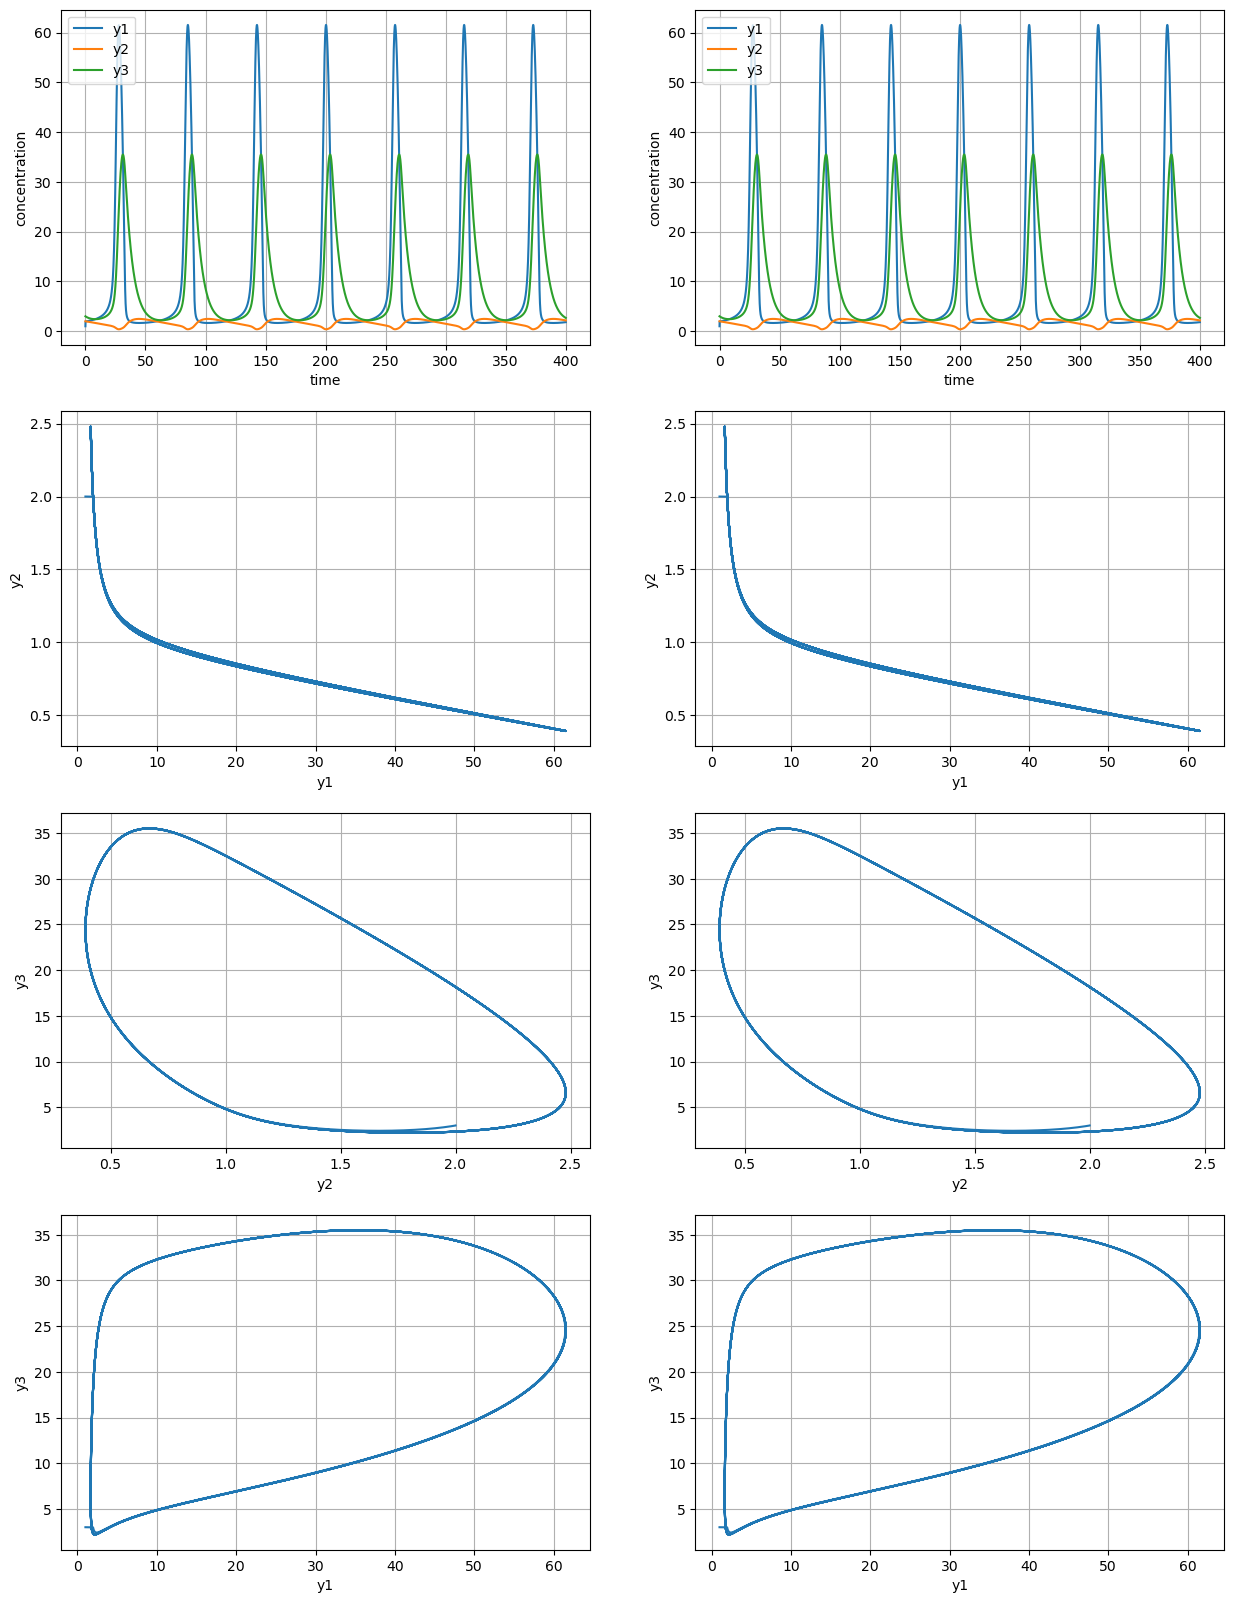

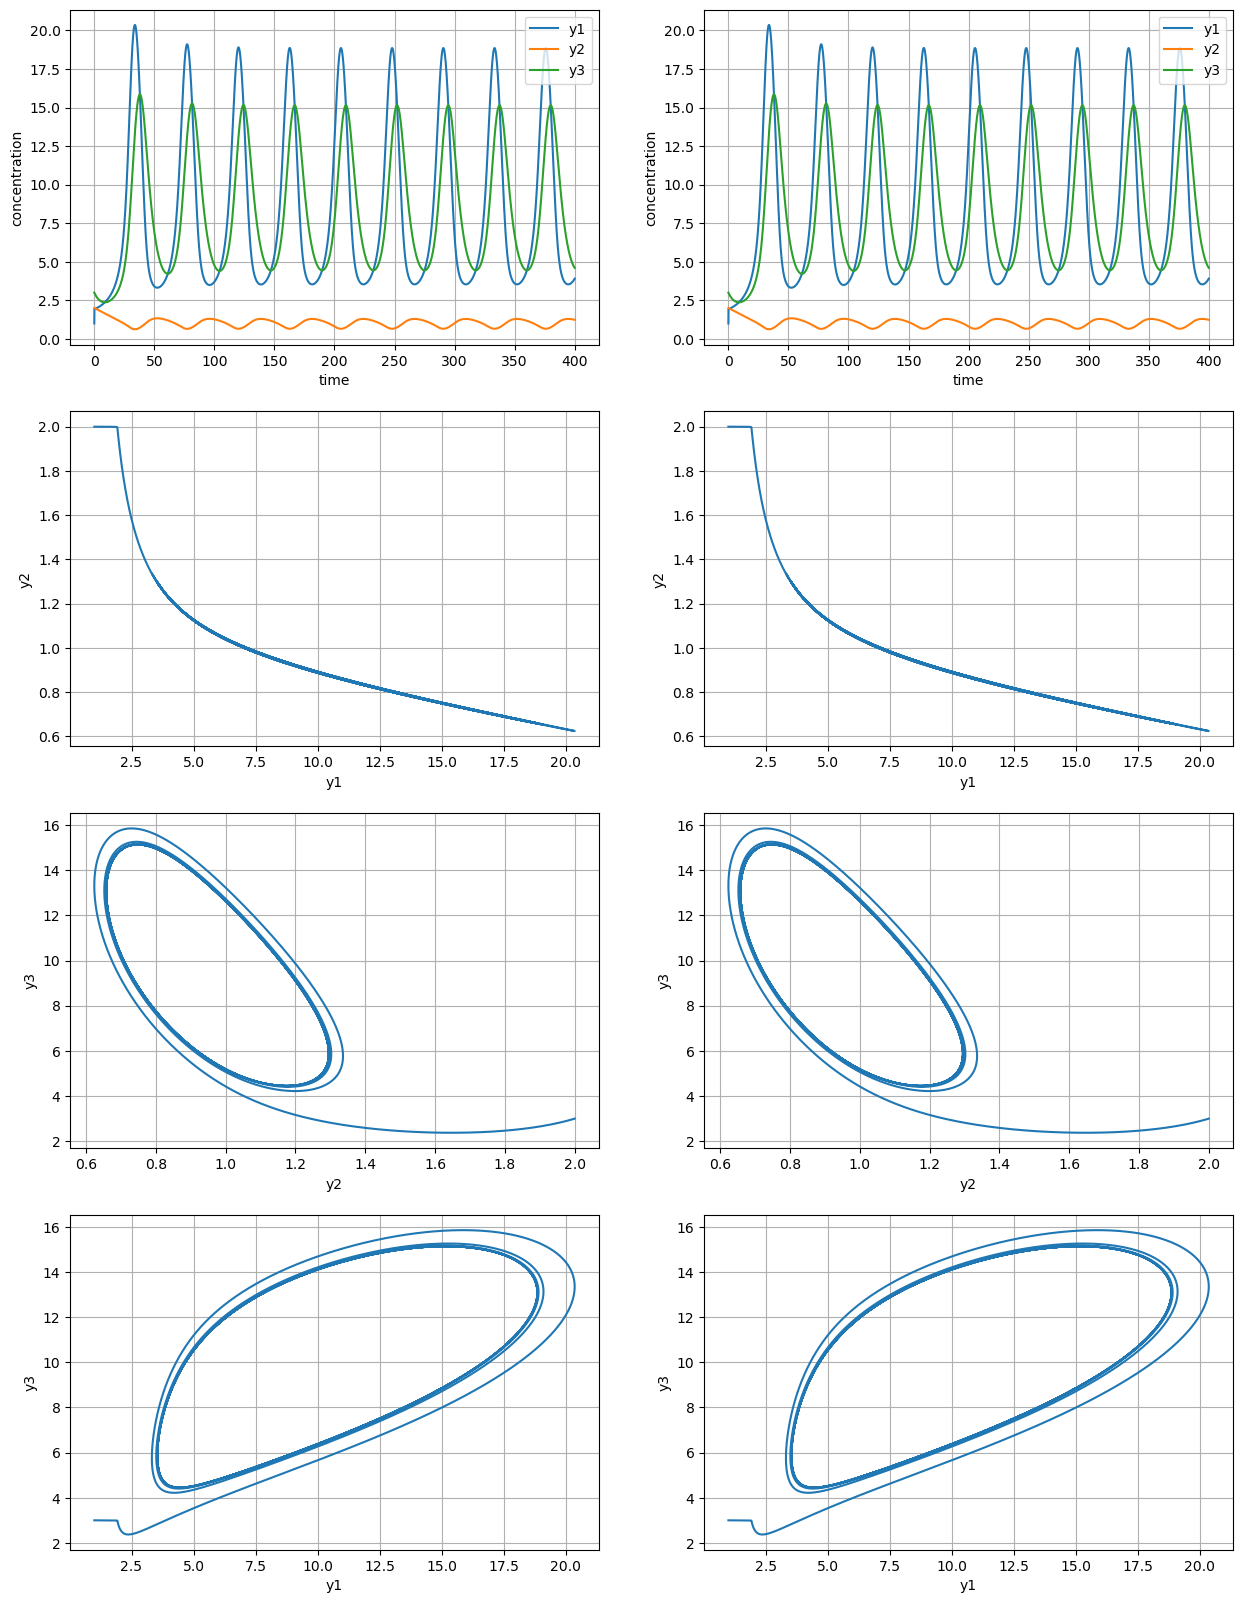

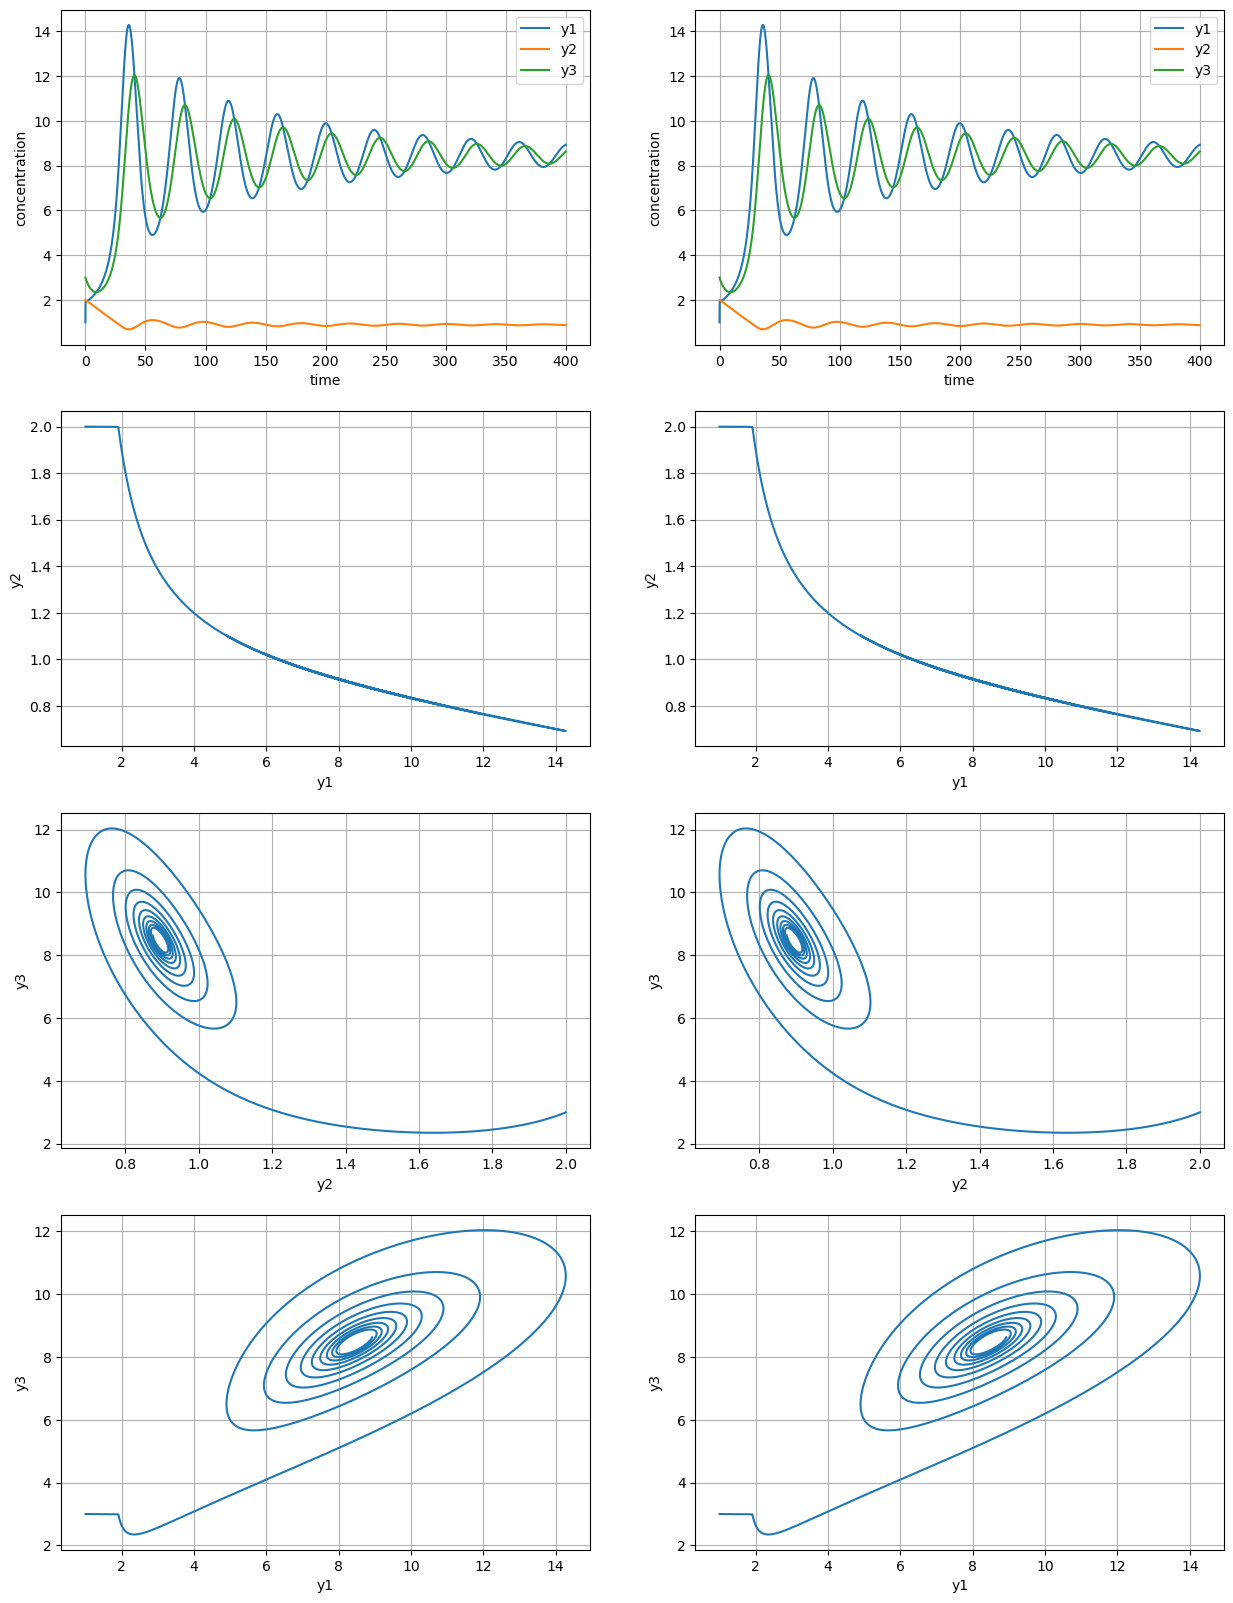

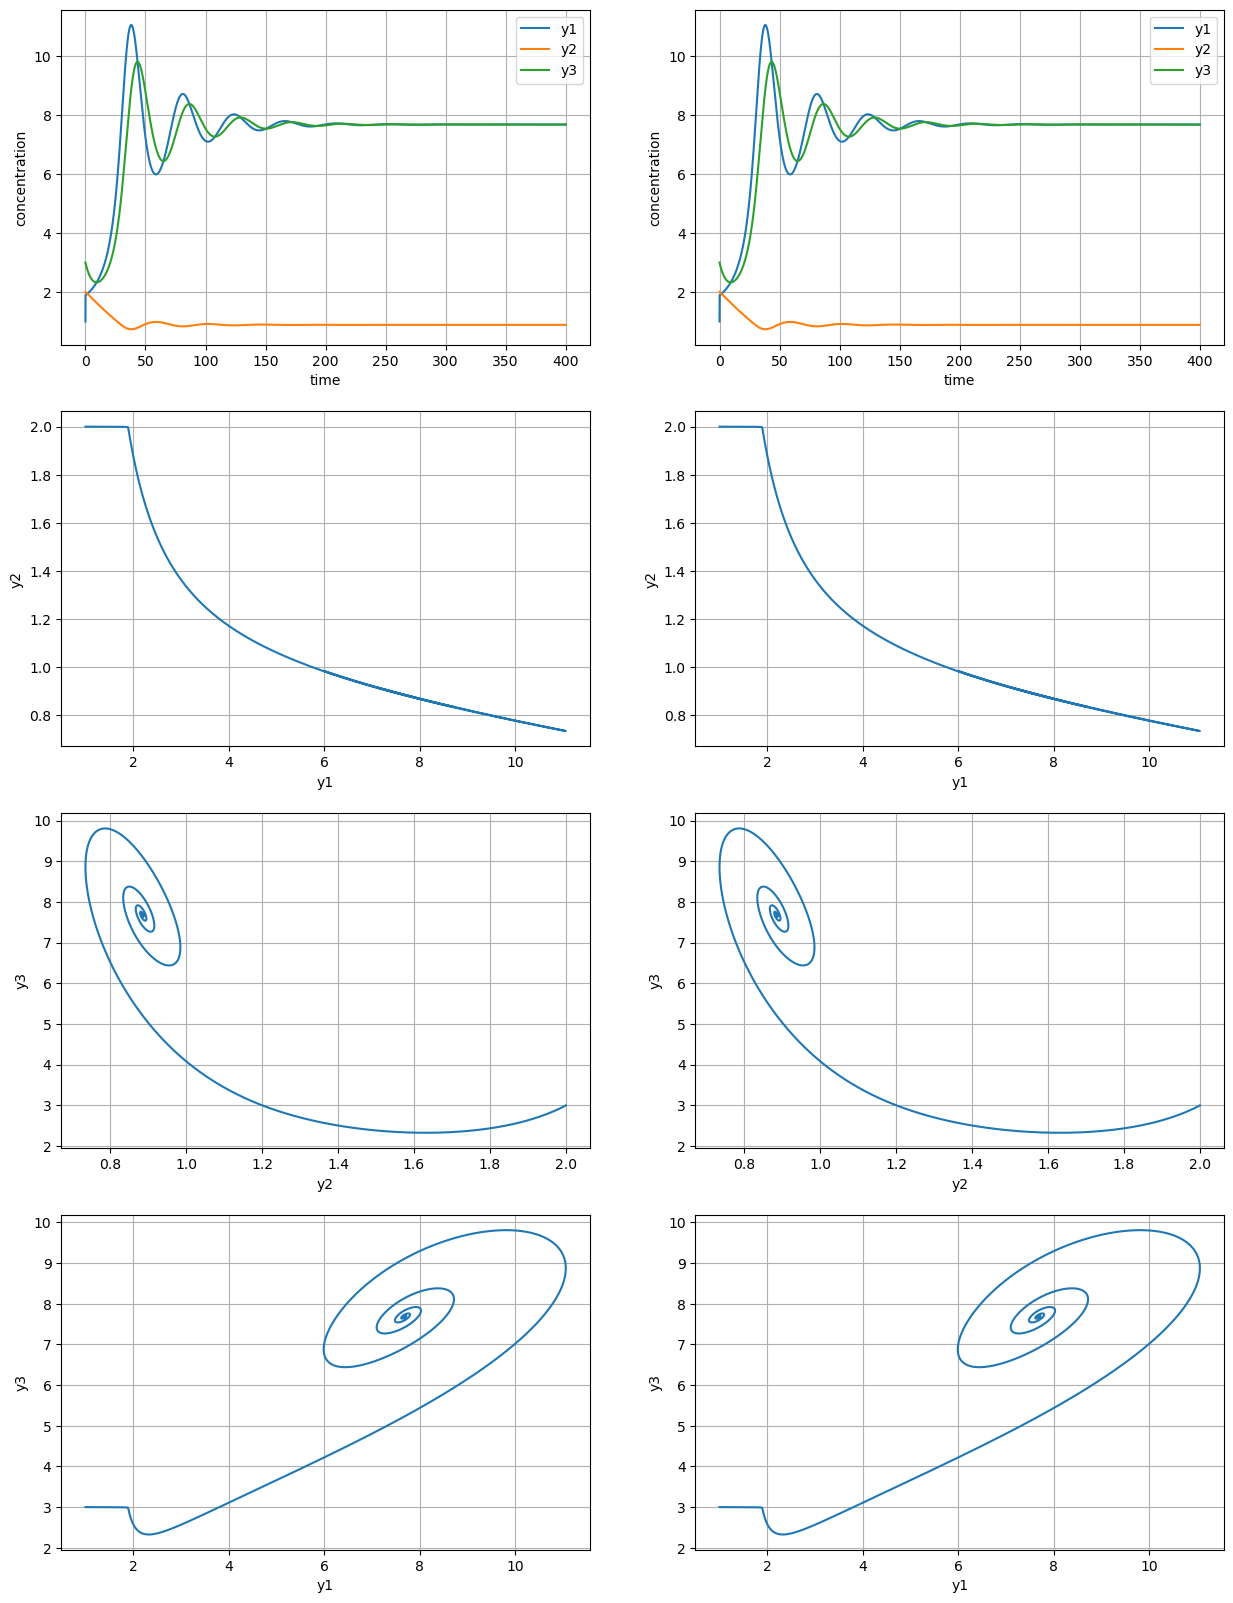

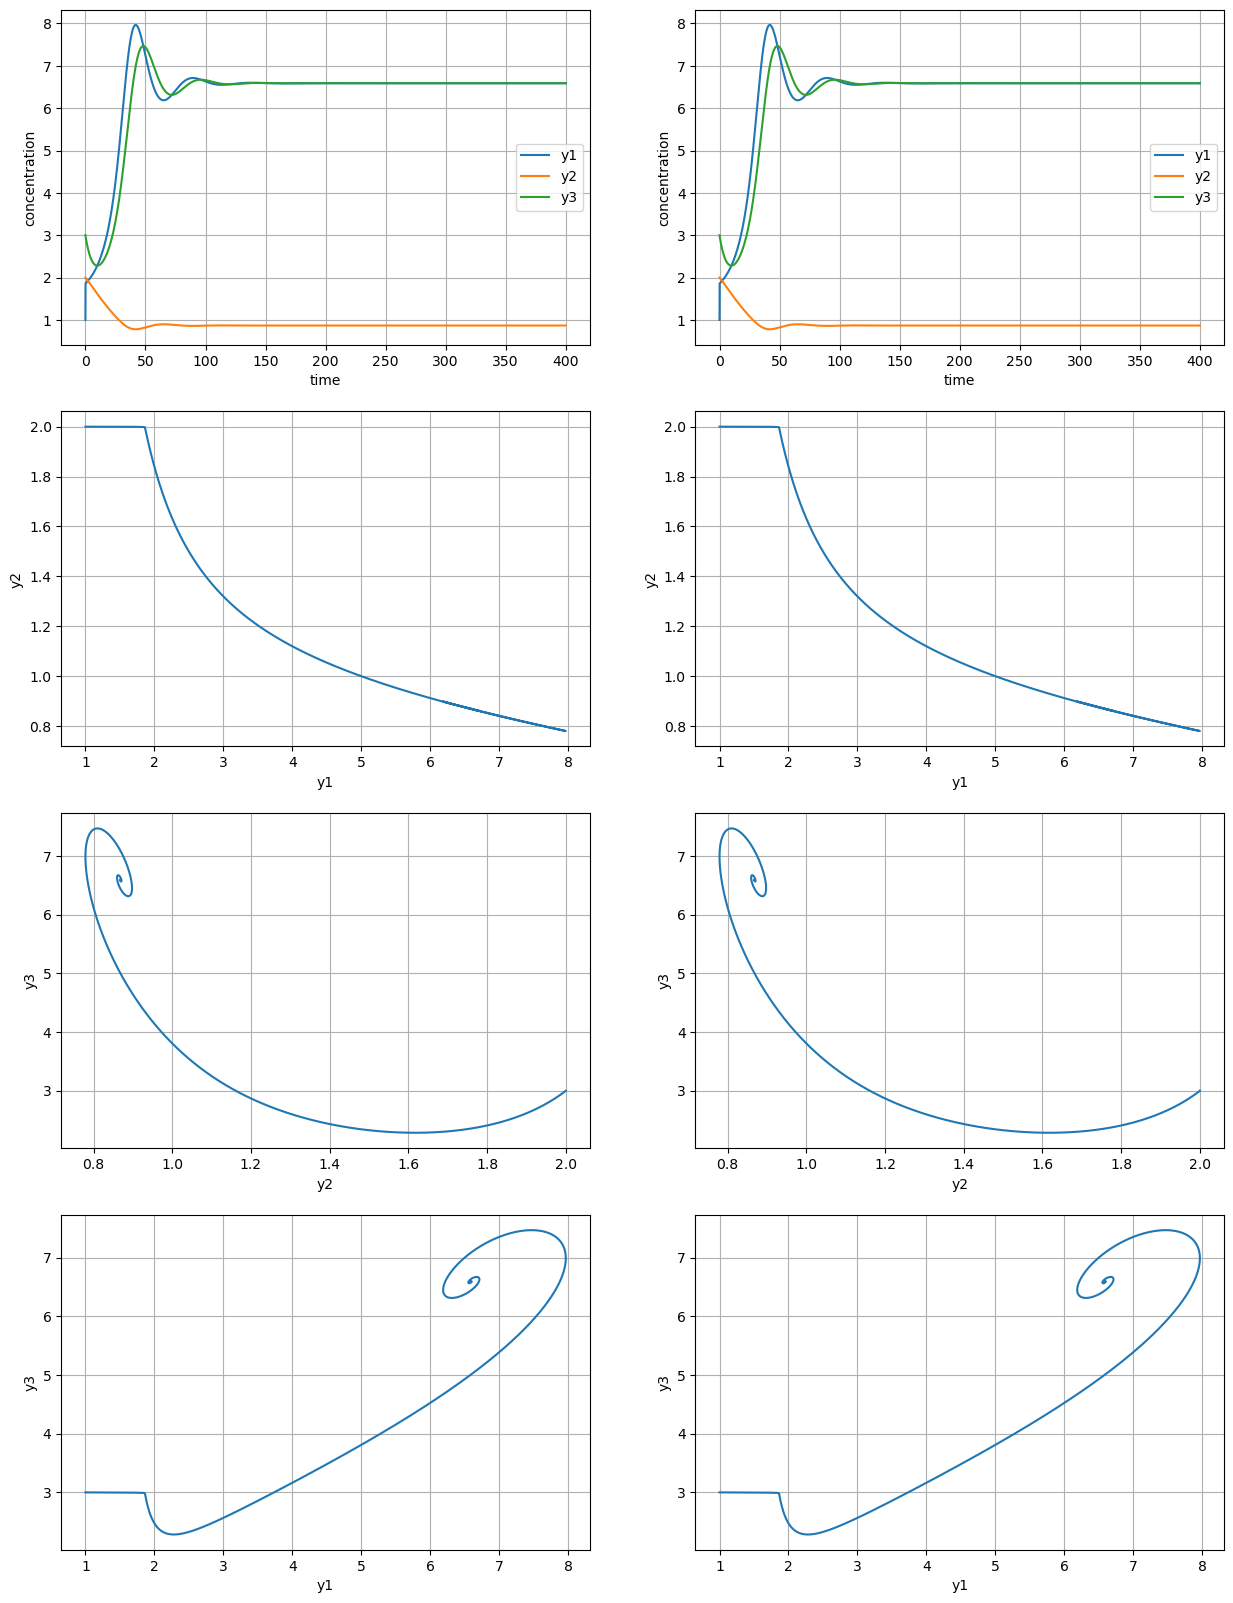

In [89]:
f = lambda x, q: np.array([(x[1] + x[0] - x[0] * x[1] - x[0] * x[0] * q) * 77.27,
                           (x[2] - x[1] - x[0] * x[1]) / 77.27,
                           0.16 * (x[0] - x[2])])

def plot_graph(tau, tlen, q):
    f_ = lambda x: f(x, q)
    zhabe(f_, tau, tlen, q, 1.0, 2.0, 3.0)

plot_graph(0.001, 400.0, 0.01)
plot_graph(0.001, 400.0, 0.02)
plot_graph(0.001, 400.0, 0.025)
plot_graph(0.001, 400.0, 0.03)
plot_graph(0.001, 400.0, 0.04)

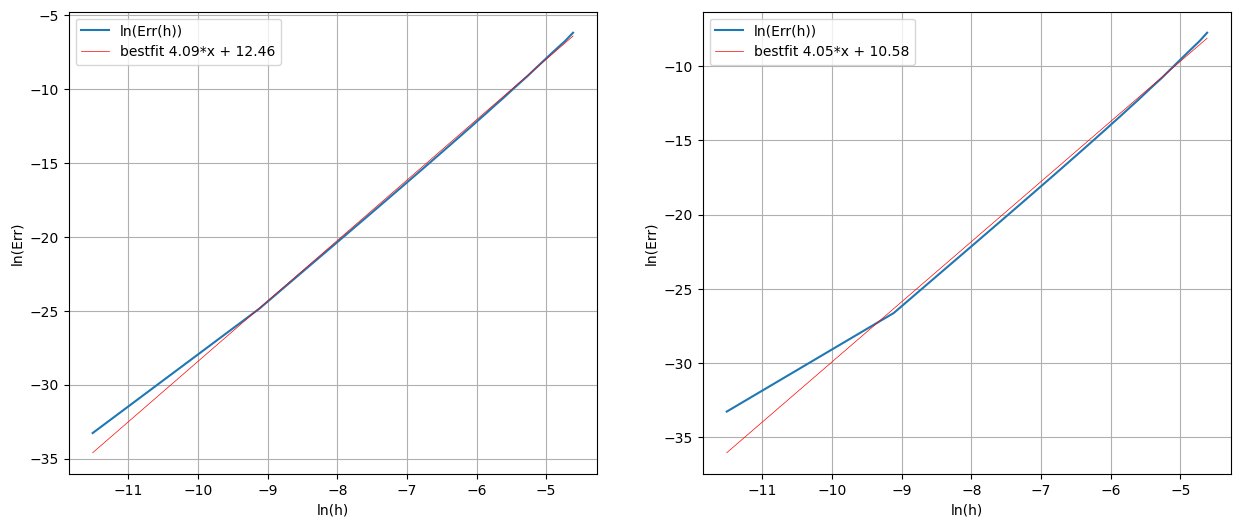

In [88]:
def plot_convergence(dx, x0, y0, z0, begin_h, end_h, step_h):
    gf_err_ex = GridFunction(begin_h, end_h, step_h)
    gf_err_im = GridFunction(begin_h, end_h, step_h)
    for i in range(gf_err_ex.n):
        tau = gf_err_ex.x[i]
        tlen = tau * 100.0

        gf_ex1 = GridFunction(0.0, tlen, tau, 3)
        gf_im1 = GridFunction(0.0, tlen, tau, 3)
        gf_ex1.y[0] = np.array([x0, y0, z0])
        gf_im1.y[0] = np.array([x0, y0, z0])
        rk4_ex(gf_ex1, dx)
        rk4_im(gf_im1, dx)

        gf_ex2 = GridFunction(0.0, tlen, tau * 0.5, 3)
        gf_im2 = GridFunction(0.0, tlen, tau * 0.5, 3)
        gf_ex2.y[0] = np.array([x0, y0, z0])
        gf_im2.y[0] = np.array([x0, y0, z0])
        rk4_ex(gf_ex2, dx)
        rk4_im(gf_im2, dx)

        gf_err_ex.y[i] = m.log(np.amax(np.absolute(gf_ex1.y - gf_ex2.y[::2])))
        gf_err_im.y[i] = m.log(np.amax(np.absolute(gf_im1.y - gf_im2.y[::2])))

        gf_err_ex.x[i] = m.log(gf_err_ex.x[i])
        gf_err_im.x[i] = m.log(gf_err_im.x[i])

    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].grid(); axis[1].grid()
    axis[0].set(xlabel='ln(h)', ylabel='ln(Err)')
    axis[1].set(xlabel='ln(h)', ylabel='ln(Err)')

    gf_err_ex.plot(ext_plt=axis[0], label='ln(Err(h))')
    gf_err_im.plot(ext_plt=axis[1], label='ln(Err(h))')

    k_ex, b_ex = np.polyfit(gf_err_ex.x, gf_err_ex.y, 1)
    k_im, b_im = np.polyfit(gf_err_im.x, gf_err_im.y, 1)
    label_str_ex = 'bestfit {:.2f}*x + {:.2f}'.format(k_ex, b_ex)
    label_str_im = 'bestfit {:.2f}*x + {:.2f}'.format(k_im, b_im)
    axis[0].plot(gf_err_ex.x, k_ex * gf_err_ex.x + b_ex, 'r-', linewidth=0.5, label=label_str_ex)
    axis[1].plot(gf_err_im.x, k_im * gf_err_im.x + b_im, 'r-', linewidth=0.5, label=label_str_im)
    axis[0].legend()
    axis[1].legend()

    fig.savefig('convergence_plot.png')

f_ = lambda x: f(x, 0.01)
plot_convergence(f_, 1.0, 2.0, 3.0, 0.00001, 0.01, 0.0001)